# Diabetes Prediction with Artificial Neural Network

MLP (Multi Layer Perceptron) Classifier is the feedforward artificial neural network implementation of Scikit-Learn library.

MLPClassifier is used to predict whether a patient has diabetes based on a set of diagnostics.

Outline of Work is as follows:

* Load Data
* Split Data
* Visualization and Outlier Check
* Standardization
* Correlation Analysis
* Feature Importance
* Train MLP
* Test MLP
* Prediciton

# Importing required libraries

In [1]:
import numpy as np
import itertools
import os
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
data = pd.read_csv("diabetes.csv")
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


The dataset contains information on diabetes-related features and an outcome variable.
* Pregnancies
* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI (Body mass index)
* DiabetesPedigreeFunction
* Age


Features are assigned to data_X and corresponding labels to data_Y. Pandas info shows column (feature) data types and number of non-null values.

In [3]:
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Outcome"]
data_Y = data[["Outcome"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Outcome  768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


In [4]:
data["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

There are two classes as expected, a patient has diabetes or doesn't have

In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Split Data
Dataset is divided into train and test sets. We use stratify parameter of train_test_split function to get the same class distribution across train and test sets.

In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

## Visualization and Outlier Check

Outliers degrade the learning performance. Outlier analysis is performed for each feature one-by-one. We use quartile analysis for outlier detection. For each feature, there are two plots below. Distribution of feature is on the left. Box plot of the same feature is on the right. Both of them are analyzed together to get an idea about the outliers. From this point on, lower whisker of the boxplot is denoted as LW and upper whisker is denoted as UW.

In [7]:
def plots(feature):
    fig = plt.figure(constrained_layout=True, figsize=(10, 3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0, :3])
    sea.histplot(train_X.loc[train_Y["Outcome"] == 0, feature],
                 kde=False, color="#004a4d", stat="count",
                 alpha=0.8, bins=40,
                 label="Not Diabetes", ax=ax1);
    sea.histplot(train_X.loc[train_Y["Outcome"] == 1, feature],
                 kde=False, color="#7d0101", stat="count",
                 alpha=0.6, bins=40,
                 label="Diabetes", ax=ax1);
    ax2 = fig.add_subplot(gs[0, 3])
    sea.boxplot(train_X[feature], orient="v", color="#989100",
                width=0.2, ax=ax2);

    ax1.legend(loc="upper right")
    plt.show()


Ther are total 8 features in the dataset as mentioned above

### Feature 0 - Pregnancies

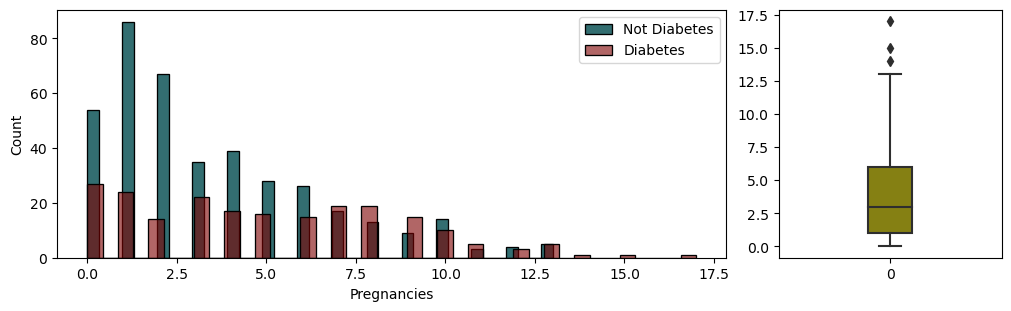

In [8]:
plots("Pregnancies")

### Feature 1 - Glcouse

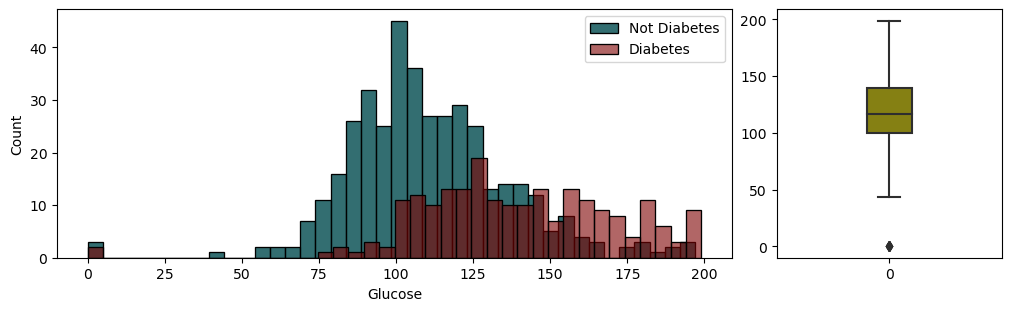

In [9]:
plots("Glucose")

###  Feature 2 - BloodPressure

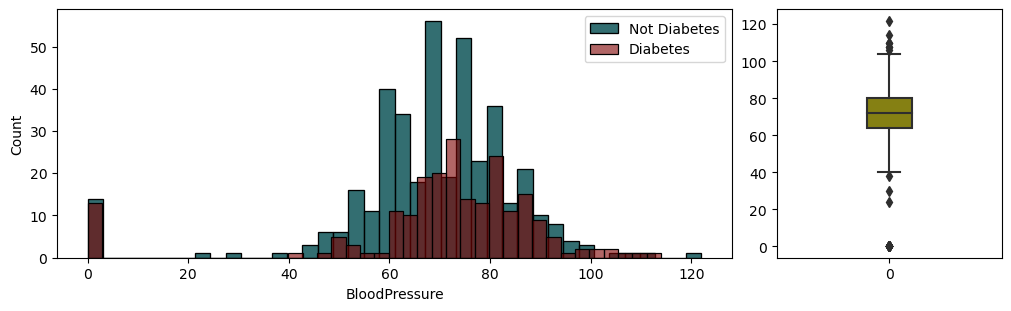

In [10]:
plots("BloodPressure")

###  Feature 3 - SkinThickness

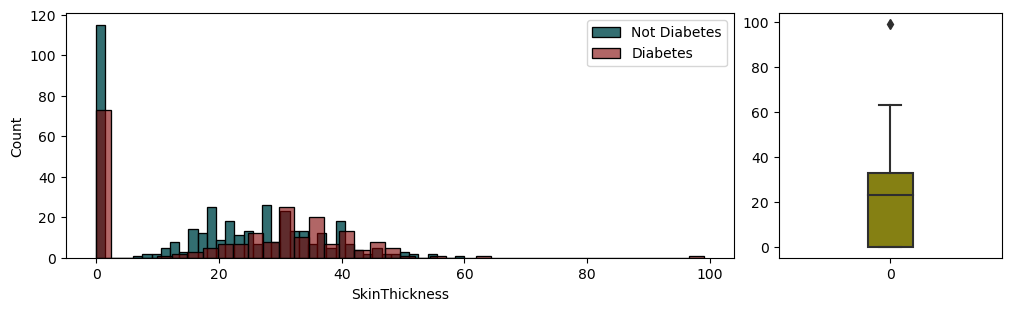

In [11]:
plots("SkinThickness")

###  Feature 4 - Insulin

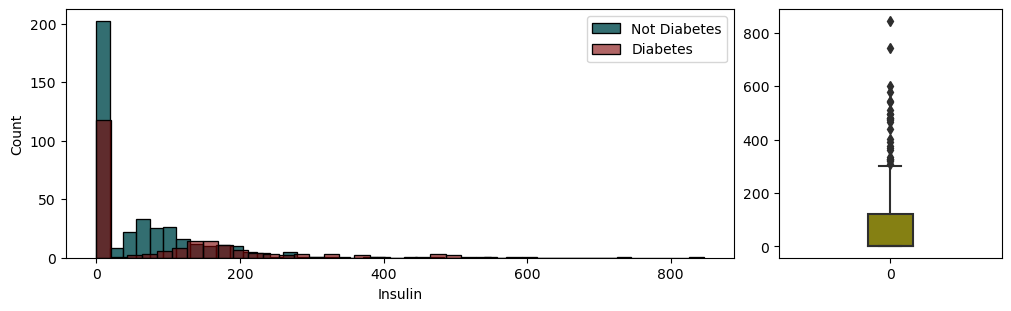

In [12]:
plots("Insulin")

###  Feature 5 - BMI

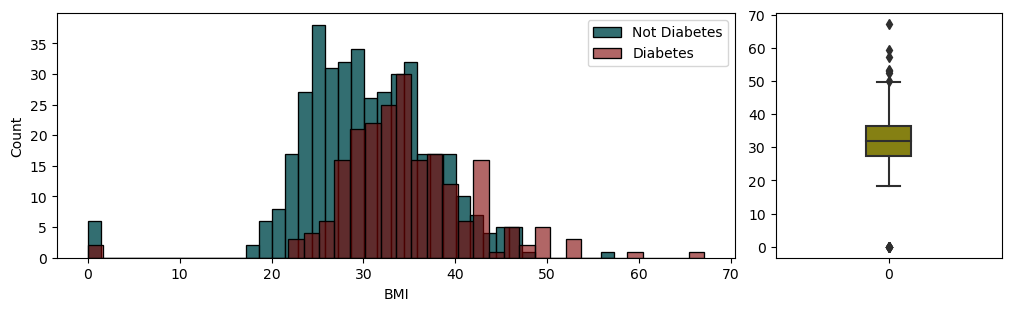

In [13]:
plots("BMI")

###  Feature 6 - DiabetesPedigreeFunction

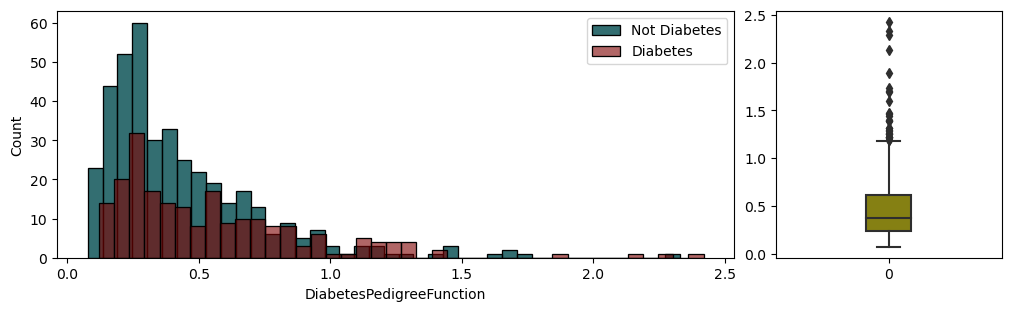

In [14]:
plots("DiabetesPedigreeFunction")

###  Feature 7 - Age

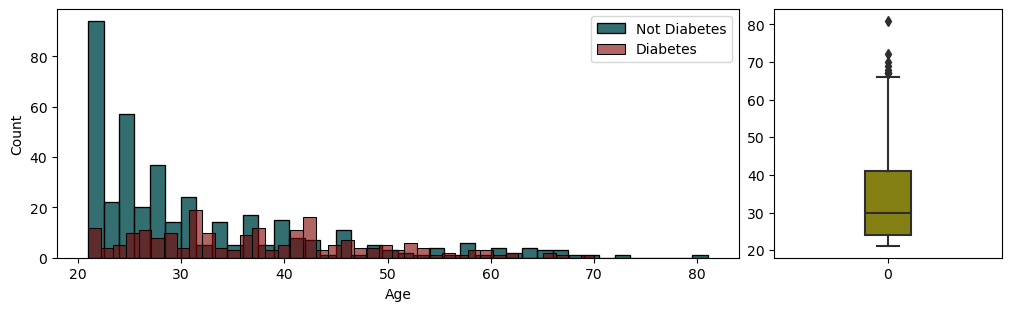

In [15]:
plots("Age")

## Standardization
To increase the learning performance, input features are standardized. Mean and standard deviation of the feature are computed. Then, mean is subtracted from each sample of the feature and result is divided by standard deviation. The aim is to transform the feature to have mean of 0 and standard deviation of 1. StandardScaler of scikit-learn is used. A StandardScaler is fit to the feature in train_X, then this scaler transforms the same feature in train_X and test_X.

In [16]:
feature_names = train_X.columns

scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

## Correlation Analysis
Linear correlations between features and also between features and output are computed. Pandas corr function is used to compute correlation matrix and Seaborn heatmap is used for plotting.

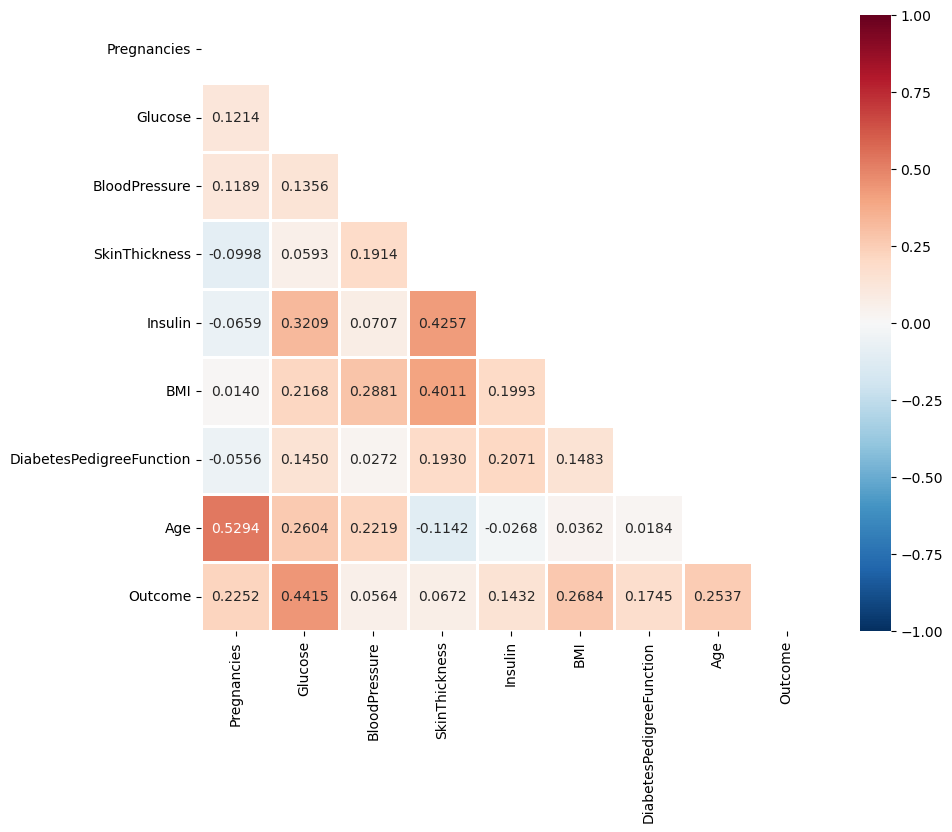

In [17]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Use `dtype=bool` instead of `dtype=np.bool`

plt.figure(figsize=(10, 8))
sea.heatmap(corr_matrix, annot=True, fmt=".4f",
            vmin=-1, vmax=1, linewidth=1,
            center=0, mask=mask, cmap="RdBu_r")
plt.show()


Correlation matrix shows that there are mild correlations between SkinThickness-BMI and Age-Pregnancies. Outcome has the highest linear correlation with Glucose

## Feature Importance
Feature importance analysis methods can be divided into 3 broad categories:

* Filter method: Calculating a metric like correlation coefficient between each feature and output separately as we did above. In this method all features are evaluated independently.

* Embedded methods: Methods like logistic regression or linear regression learn the coefficients that multiply each feature. The magnitude of the coefficients are associated with the importance of the features. Also, tree based methods like random forests or gradient tree boosting learn feature importances during training process. In embedded methods, all features are evaluated jointly.

* Wrapper methods: Basically you have an estimator and you train this estimator with the subsets of features. The subset giving the best score is selected and other features are eliminated.

In [18]:
# logistic regression with l1 penalty - embedded method
lr1 = LogisticRegression(random_state=0, penalty="l1",
            class_weight="balanced", solver="saga", max_iter=5000)
lr1.fit(train_X, train_Y.values.ravel())

lr1.coef_

array([[ 0.39364626,  0.9679934 , -0.20709859, -0.03050567, -0.03410318,
         0.60675803,  0.32161103,  0.28384789]])

In [19]:
# logistic regression with l2 penalty - embedded method
lr2 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
lr2.fit(train_X, train_Y.values.ravel())

lr2.coef_

array([[ 0.39795075,  0.97094293, -0.21787653, -0.03835216, -0.04136554,
         0.62013787,  0.33173143,  0.29051971]])

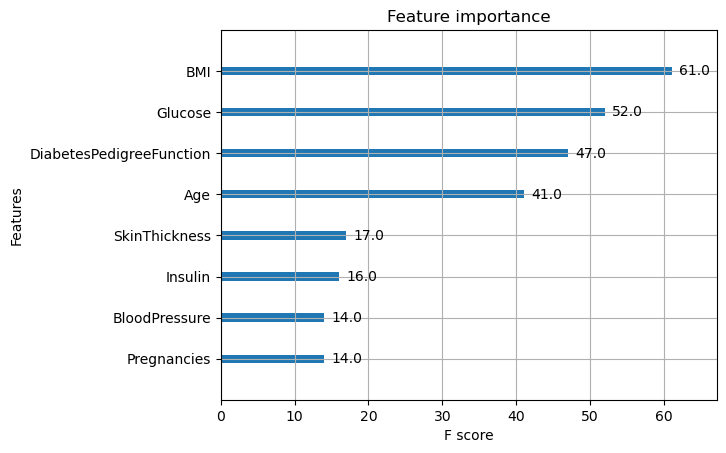

In [20]:
# xgboost - embedded method
gb = xgb.XGBClassifier(booster="gbtree",
                      learning_rate=0.15,
                      max_depth=4,
                      n_estimators=20,
                      random_state=0)
gb.fit(train_X, train_Y.values.ravel())

plot_importance(gb);

In [21]:
# recursive feature elimination with logistic regression - wrapper method
lr3 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
rfe_lr3 = RFE(lr3, n_features_to_select=7)
rfe_lr3.fit(train_X, train_Y.values.ravel())

print(rfe_lr3.support_)

[ True  True  True False  True  True  True  True]


First three analysis mark BloodPressure, SkinThickness and Insulin as the least important features. Note that these features have very low correlation with Outcome. RFE marks SkinThickness as the least important.

In [22]:
train_X.drop("SkinThickness", axis=1, inplace=True)
test_X.drop("SkinThickness", axis=1, inplace=True)

## Train MLP
MLPClassifier with single hidden layer is used for diabetes prediction.

In [23]:
clf = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),                      
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

clf.fit(train_X, train_Y.values.ravel());

## Test MLP

In [24]:
print(classification_report(test_Y, clf.predict(test_X),
                            digits = 4,
                            target_names=["Not Diabetes",
                                          "Diabetes"]))

              precision    recall  f1-score   support

Not Diabetes     0.8505    0.9100    0.8792       100
    Diabetes     0.8085    0.7037    0.7525        54

    accuracy                         0.8377       154
   macro avg     0.8295    0.8069    0.8159       154
weighted avg     0.8358    0.8377    0.8348       154



In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

# Make predictions on the test set
predictions = clf.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_Y, predictions)

# Calculate precision, recall, and F1-score
precision = precision_score(test_Y, predictions)
recall = recall_score(test_Y, predictions)
f1 = f1_score(test_Y, predictions)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(test_Y, predictions)

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Accuracy: 0.8377
Precision: 0.8085
Recall: 0.7037
F1 Score: 0.7525
Cohen's Kappa: 0.6326
Sensitivity: 0.7037
Specificity: 0.9100


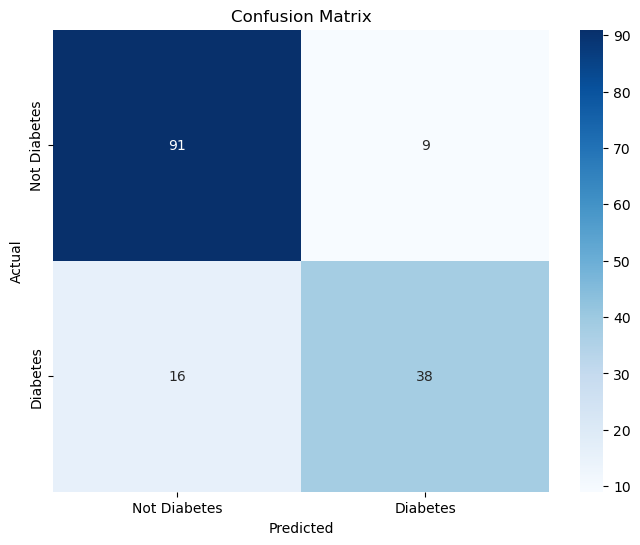

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_Y, predictions)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Diabetes', 'Diabetes'],
            yticklabels=['Not Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


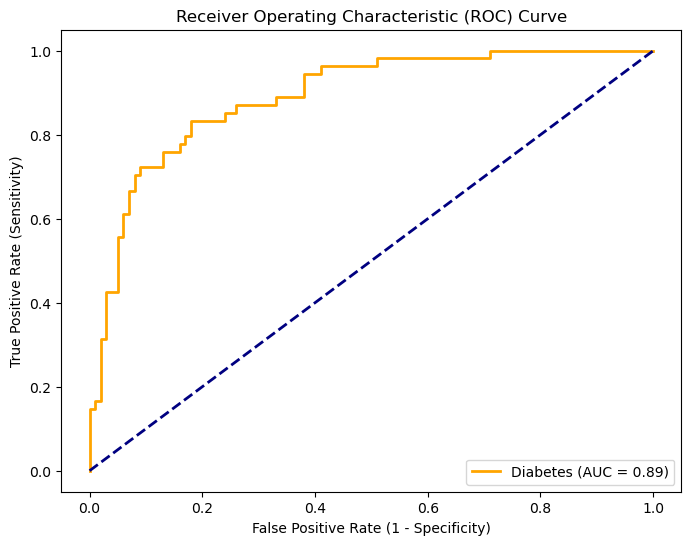

In [29]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for both classes
probs = clf.predict_proba(test_X)
diabetes_probs = probs[:, 1]  # Probabilities for class "Diabetes"

# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, thresholds = roc_curve(test_Y, diabetes_probs)

# Calculate AUC (Area Under the Curve)
auc_value = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Diabetes (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [30]:
number_of_features = clf.n_features_in_
print("Number of features used during training:", number_of_features)

# Assuming you have feature names available in 'feature_names'
print("Features trained on:")
print(feature_names)


Number of features used during training: 7
Features trained on:
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


In [31]:
from sklearn.preprocessing import StandardScaler

# Assuming you have your training data in a DataFrame called 'train_X'
scaler = StandardScaler()
scaler.fit(train_X)

# Save the scaler to a file
import pickle
pickle.dump(scaler, open("scaler.pkl", "wb"))


In [32]:
# Assuming you've alacready trained your model (e.g., clf in your code)
from sklearn.neural_network import MLPClassifier  # Adjust if using a different model

# Save the trained model to a file
import pickle
pickle.dump(clf, open("diabetes_model.pkl", "wb"))


In [42]:
import pickle
import pandas as pd
import warnings

# Load the scaler
with open("scaler.pkl", "rb") as scaler_file:
    scaler = pickle.load(scaler_file)

# Load the trained model
with open("diabetes_model.pkl", "rb") as model_file:
    clf = pickle.load(model_file)

# Function to predict diabetes
def predict_diabetes(model, scaler):
    feature_names = ["Pregnancies", "Glucose", "BloodPressure","Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
    
    user_input = []
    for feature_name in feature_names:
        value = float(input(f"Enter the value for {feature_name}: "))
        user_input.append(value)
    
    # Set column names for user input
    features = pd.DataFrame([user_input], columns=feature_names)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Suppress specific warning
        scaled_features = scaler.transform(features)
    
    prediction = model.predict(scaled_features)
    
    if prediction[0] == 1:
        return "Likely to have diabetes"
    else:
        return "Unlikely to have diabetes"

# Make predictions
result = predict_diabetes(clf, scaler)
print("Prediction:", result)


Enter the value for Pregnancies: 6
Enter the value for Glucose: 148
Enter the value for BloodPressure: 72
Enter the value for Insulin: 0
Enter the value for BMI: 33.6
Enter the value for DiabetesPedigreeFunction: 0.627
Enter the value for Age: 50
Prediction: Likely to have diabetes


C:\Users\akash boss\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
